In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import os

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn import preprocessing

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [3]:
train_data = []
target_data = []
dataset_path = "./dataset/train"
cat = os.listdir(dataset_path)
for c in cat:
    print(c)
    cat_path = os.path.join(dataset_path, c)
    filenames = os.listdir(cat_path)
    for f in filenames:
        image_path = cat_path + '/'+ f
        # Gray
        image = cv2.imread(image_path)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
        image = image.reshape(256, 256, 3)
        train_data.append(image)
        target_data.append(c)
        

office
opencountry
forest
insidecity
bedroom
livingroom
suburb
tallbuilding
coast
mountain
kitchen
street
highway


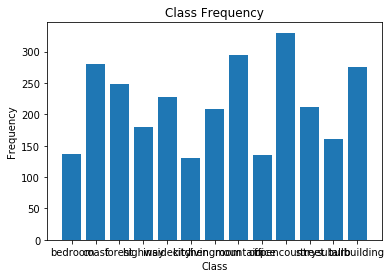

In [4]:
unique, counts = np.unique(target_data, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [5]:
le = preprocessing.LabelEncoder()
le.fit(target_data)
target_data = le.transform(target_data)
x_train, x_val, y_train, y_val = train_test_split(
    train_data, target_data, test_size=0.05)

In [6]:
y_train = to_categorical(y_train, num_classes=13)
y_val = to_categorical(y_val, num_classes=13)

In [7]:
x_train = np.array(x_train)
x_val = np.array(x_val)

In [8]:
#coding=utf-8
# Resnet 50
from keras.models import clone_model
from keras.models import Model
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D,GlobalAveragePooling2D
from keras.layers import add,Flatten
#from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D
from keras.optimizers import SGD
import numpy as np
seed = 7
np.random.seed(seed)
 
def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
 
def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)
        x = add([x,shortcut])
        return x
    else:
        x = add([x,inpt])
        return x

inpt = Input(shape=(256,256,3))
x = ZeroPadding2D((3,3))(inpt)
x = Conv2d_BN(x,nb_filter=64,kernel_size=(7,7),strides=(2,2),padding='valid')
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
 
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
 
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
# x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
# x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
 
# x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
# x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))
# x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))
x = AveragePooling2D(pool_size=(7,7))(x)
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(500,activation='relu')(x)
x = Dense(13,activation='softmax')(x)
 
model = Model(inputs=inpt,outputs=x)
sgd = SGD(decay=0.0001,momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.summary()

model_arr = []
model_count = 1
for i in range(model_count):
    print(i)
    model_tmp = clone_model(model)
    model_tmp.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    model_arr.append(model_tmp)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [9]:
from keras.applications.resnet import preprocess_input
datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)

In [10]:
len(model_arr)

1

In [11]:

# from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import preprocess_input
x_train_ = preprocess_input(x_train)
x_val_ = preprocess_input(x_val)

In [12]:
hist = []
nb_epoch = 25
for i in range(model_count):
    hist_tmp = model_arr[i].fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=nb_epoch, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(x_val_, y_val)
                           ) #validation_data=(x_val_, y_val)For speed
    hist.append(hist_tmp)

Epoch 1/25
500/500 [==============================] - 58s 116ms/step - loss: 2.2810 - acc: 0.2580 - val_loss: 2.0401 - val_acc: 0.3475
Epoch 2/25
500/500 [==============================] - 45s 90ms/step - loss: 1.6238 - acc: 0.4767 - val_loss: 1.6433 - val_acc: 0.4823
Epoch 3/25
500/500 [==============================] - 44s 89ms/step - loss: 1.2558 - acc: 0.5780 - val_loss: 1.2405 - val_acc: 0.6028
Epoch 4/25
500/500 [==============================] - 44s 89ms/step - loss: 0.9652 - acc: 0.6754 - val_loss: 0.9896 - val_acc: 0.6950
Epoch 5/25
500/500 [==============================] - 44s 89ms/step - loss: 0.7795 - acc: 0.7419 - val_loss: 1.1224 - val_acc: 0.6454
Epoch 6/25
500/500 [==============================] - 44s 89ms/step - loss: 0.6373 - acc: 0.7885 - val_loss: 0.9921 - val_acc: 0.7092
Epoch 7/25
500/500 [==============================] - 45s 89ms/step - loss: 0.5030 - acc: 0.8350 - val_loss: 1.0001 - val_acc: 0.6879
Epoch 8/25
500/500 [==============================] - 44s 89m

In [13]:
final_loss, final_acc = model_arr[0].evaluate(x_val_, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.8177, final accuracy: 0.8227


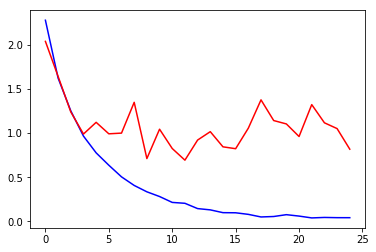

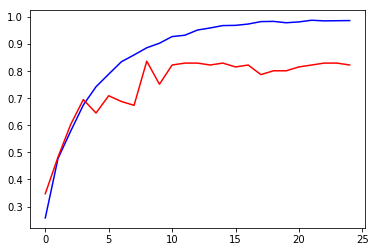

In [14]:
plt.plot(hist[0].history['loss'], color='b')
plt.plot(hist[0].history['val_loss'], color='r')
plt.show()
plt.plot(hist[0].history['acc'], color='b')
plt.plot(hist[0].history['val_acc'], color='r')
plt.show()

In [15]:
y_hat = model_arr[0].predict(x_val_)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 6  0  0  0  0  1  1  0  2  0  0  1  0]
 [ 0  8  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  5  1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0 11  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0  1]
 [ 0  5  0  1  0  0  0  0  0  6  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8]]


In [16]:
test_data = []
id_data = []
dataset_path = "./dataset/test"
filenames = os.listdir(dataset_path)
filenames.sort()
# print(filenames)
for f in filenames:
    image_path = dataset_path + '/'+ f
    # Gray
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
    image = image.reshape(256, 256, 3)
#     image = image.astype("float32")/255.
    id_data.append(f[0:-4])
    test_data.append(image)
test_data = np.array(test_data)
# x_test = mnist_testset.astype("float32")
# x_test = x_test.reshape(-1, 200, 200, 1)/255.

In [17]:
y_pred_list = []
test_data_ = preprocess_input(test_data)
for i in range(model_count):
    y_hat_tmp = model_arr[i].predict(test_data_, batch_size=64)
    y_pred_tmp = le.inverse_transform(np.argmax(y_hat_tmp,axis=1))
    y_pred_list.append(y_pred_tmp)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
y_pred = []
from collections import Counter
for i in range(len(test_data)):
    pred = []
    for j in range(model_count):
        pred.append(y_pred_list[j][i])
    pred_count = Counter(pred)
    top_one = pred_count.most_common(1)
    y_pred.append(top_one[0][0])

In [19]:
import csv

with open(str(model_count) + '_voting_resnet.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for i in range(len(y_pred)) :
        writer.writerow([id_data[i], str(y_pred[i])])